In [82]:
import skewtfit as sf
from CentralStreamingModel.utils.plot_tools import bestfit_jointplot
import CentralStreamingModel.biskewt.skewt as st
import matplotlib.pyplot as plt
import numpy as np
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection.pyprojection import projection_parallel as pj
import pickle
from CentralStreamingModel.integral.real2redshift  import compute_integrand, compute_integrand_continuous, integrate
from CentralStreamingModel.tpcfs.tpcf_tools import get_multipoles, get_wedges


In [83]:
boxsize = 2000
box = 1
snapshot = 11

measured = VD('galaxies', box, boxsize, snapshot)
measured_los = VD_los('galaxies', box, boxsize, snapshot)

In [84]:


tpcf_filename = f"/raid/c-cuesta/tpcfs/gals_real_tpcf_box{box}.pickle"

with open(tpcf_filename, "rb") as input_file:

    twopcf_dict = pickle.load(input_file)

In [85]:
rperp_bins = measured_los.r.t
rparallel_bins = measured_los.r.r
vlos_bins = measured_los.v
r_bins = measured.r
vr = measured.v.r
vt = measured.v.t
jointpdf = measured.jointpdf

In [86]:

popt, pcov = sf.radial_tangential_skewtfit(measured.r,
    measured.v.r, measured.v.t, measured.jointpdf, log=False)



In [87]:

popt_log, pcov_log = sf.radial_tangential_skewtfit(measured.r[2:],
            measured.v.r, measured.v.t, measured.jointpdf[2:], log=True)

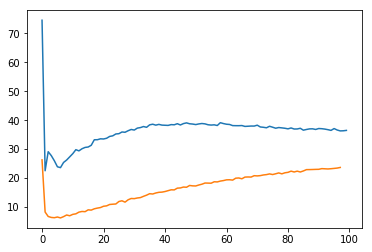

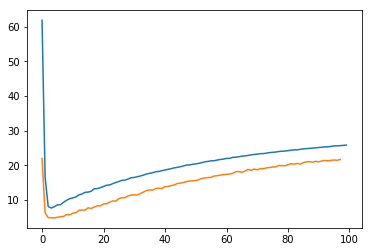

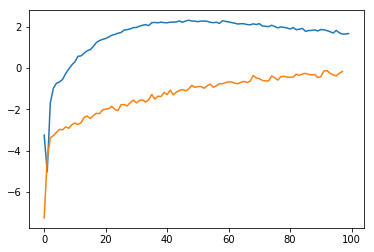

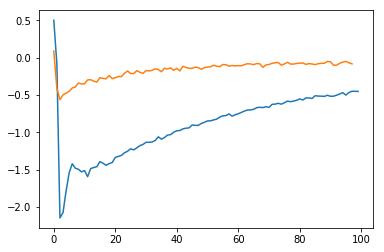

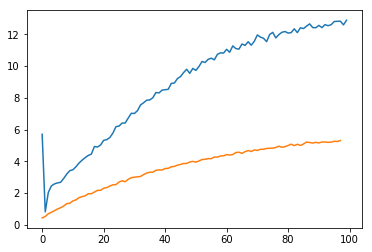

In [88]:
for i in range(5):
    plt.plot(popt[:,i])
    plt.plot(popt_log[:,i]) 
    plt.show()

In [117]:
v_r = measured.v.r
v_t = measured.v.t

r = np.arange(0.5, 100, 1.)

v = np.array(np.meshgrid(v_r, v_t)).T.reshape(-1,2)

skewt = []

for rbin in range(len(r)):


    skewt.append(st.skewt(v, *popt[rbin]).reshape(v_t.shape[0], v_r.shape[0]))

skewt = np.asarray(skewt)


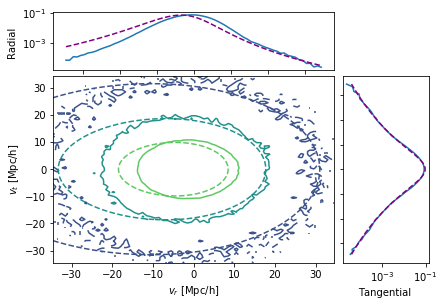

In [122]:
rbin_show = 50
bestfit_jointplot(v_r, v_t, measured.jointpdf[rbin_show], skewt[rbin_show], log=True, log_marginals=True)

In [127]:
v_r = measured.v.r
v_t = measured.v.t

r = np.arange(0.5, 100, 1.)

v = np.array(np.meshgrid(v_r, v_t)).T.reshape(-1,2)

skewt = []

for rbin in range(len(r)):
    mod_popt = popt[rbin].copy()
    if (rbin > 2):
        mod_popt[0] = popt_log[rbin-2, 0]

        mod_popt[-4] = popt_log[rbin-2, -4]

        mod_popt[-3] = popt_log[rbin-2, -3]
        mod_popt[-2] = popt_log[rbin-2, -2]

        mod_popt[-1] = popt_log[rbin-2, -1]

    skewt.append(st.skewt(v, *mod_popt).reshape(v_t.shape[0], v_r.shape[0]))

skewt = np.asarray(skewt)


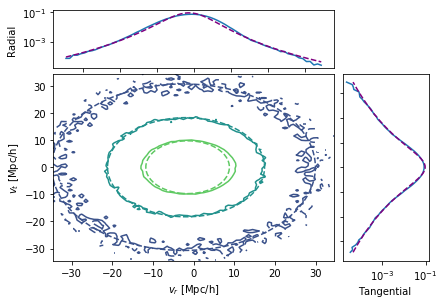

In [128]:
bestfit_jointplot(v_r, v_t, measured.jointpdf[rbin_show], skewt[rbin_show], log=True, log_marginals=True)

In [129]:
st_los_pdf = pj(rperp_bins, rparallel_bins,
                    vlos_bins, r_bins, vr, vt, 
                    skewt, interpolate=True, n_cores=10)

In [130]:
def streaming_model(s_paral_full, v_los, real_tpcf_dict, jointpdf_los):
    s = np.arange(0., 50., 1.) 
    s_c = 0.5 * (s[1:] + s[:-1])

    print('Computing streaming integral')
    int_r_parallel, integrand = compute_integrand(s, s, 
            real_tpcf_dict, jointpdf_los, s_paral_full, v_los)

    
    pi_sigma = integrate(int_r_parallel, integrand)
    
    return s_c, pi_sigma


In [131]:
s_c, pi_sigma = streaming_model(rparallel_bins, vlos_bins, twopcf_dict, measured_los.jointpdf )

Computing streaming integral


In [132]:
s_c, pi_sigma_combined = streaming_model(rparallel_bins, vlos_bins, twopcf_dict,st_los_pdf )

Computing streaming integral


In [133]:
s_mu_st, monopole_st, quadrupole_st, hexadecapole_st = \
            get_multipoles(s, pi_sigma_combined, s, mu_bins)


In [134]:
s = np.arange(0., 50., 1.) 

n_mu_bins = 120
mu_bins = np.linspace(0.,1.,n_mu_bins)

s_mu, monopole, quadrupole, hexadecapole = \
            get_multipoles(s, pi_sigma, s, mu_bins)


In [135]:
n_wedges = 5
wedges_bins = np.linspace(0.,1, n_wedges + 1)

wedges = get_wedges(s_c, s_mu, mu_bins, wedges_bins)

wedges_st = get_wedges(s_c, s_mu_st, mu_bins, wedges_bins)


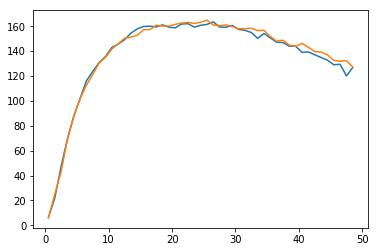

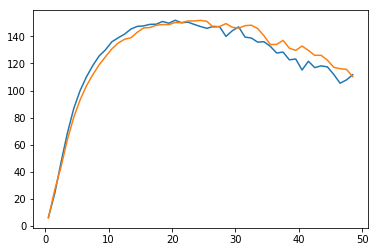

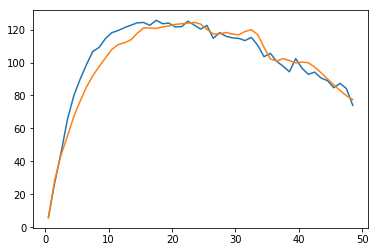

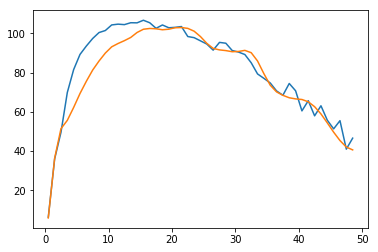

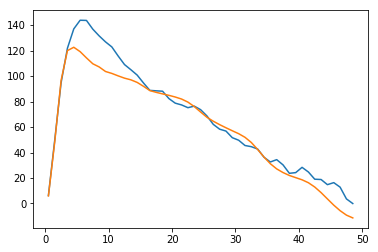

In [136]:
for i in range(len(wedges)):
    plt.plot(s_c, s_c*s_c*wedges[i])
    plt.plot(s_c, s_c*s_c*wedges_st[i])

    plt.show()